In [1]:
# hide
# all_slow
# all_no_test

In [2]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq pyarrow fastparquet
! [ -e /content ] && pip install -Uqq folium mapclassify
! [ -e /content ] && pip install -Uqq geowrangler

In [3]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [4]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Exploring Internet Speeds with Ookla  

> A simple use case demo for using geowrangler modules to find the Philippine provinces/towns with the slowest/fastest internet speeds.  

## Summary

This **Use Case Demo** shows how to use the [_geowrangler.datasets.ookla_](./datasets_ookla.html) and the [*geowrangler.area_zonal_stats*](./area_zonal_stats.html) modules to find the slowest/fastest internet speeds within an area or region of interest.


### How geowrangler can make this process easier

Geowrangler can:

* Validate your geodataframes
* Help you download Ookla data (internet speed)
* Generate zonal stats for your province/town

### What you need to do

* Get your AOIs (areas of interest) - get the boundaries of your administrative regions
* Download ookla data
* Validate AOIs and ookla data
* Generate zonal Stats
* Analyze and find fastest/slowest internet speeds

In [5]:
# hide
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning, module="geopandas")

## Tutorial 


### Import libraries

Lets start by importing the required libraries

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import geowrangler.area_zonal_stats as azs

In [7]:
# hide
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

In [8]:
# hide
# no_test
!mkdir -p ../data

### Download Admin Areas

Next, we get the administrative boundaries geodataset using [data from Humanitarian Data Exchange](https://data.humdata.org/dataset/cod-ab-phl)  

#### Set Region Filter
> Important: setting the region filter to `None` will compute the zonal stats for the whole Philippines and can take a lot longer than for a region

Set the **REGION_FILTER** to your Region (or `None` for the whole Philippines)

In [9]:
# REGION_FILTER = None  # All regions
REGION_FILTER = "National Capital Region"  # limit to 1 to speed up processing

Download the geodataset containing the admin areas of your country.

Here we are using the data for the Philippines.

In [10]:
# no_test
phl_admin3_file = "phl_adminboundaries_candidate_adm3"
phl_admin3_zip = f"{phl_admin3_file}.zip"
# shapefiles
phl_admin3_link = f"https://data.humdata.org/dataset/caf116df-f984-4deb-85ca-41b349d3f313/resource/12457689-6a86-4474-8032-5ca9464d38a8/download/{phl_admin3_zip}"

Download the zipped file. Depending on your internet connection, it can take several minutes.

In [11]:
%%time
# no_test
![ ! -e ../data/{phl_admin3_zip} ] && curl -L -o ../data/{phl_admin3_zip} {phl_admin3_link}

CPU times: user 3.9 ms, sys: 12.6 ms, total: 16.5 ms
Wall time: 123 ms


In [12]:
!mkdir -p ../data/{phl_admin3_file}

In [13]:
main_file = "phl_admbnda_adm3_psa_namria_20200529"
phl_admin3_shp = f"../data/{phl_admin3_file}/{main_file}.shp"

In [14]:
%%time
![ ! -e {phl_admin3_shp} ] && unzip -d ../data/{phl_admin3_file} ../data/{phl_admin3_zip}

CPU times: user 5.08 ms, sys: 3.09 ms, total: 8.17 ms
Wall time: 112 ms


Load the admin area geo dataset. 

In our example we are loading the `.shp` or shape file as a geopandas dataframe.

In [15]:
%%time
print(f"loading {phl_admin3_shp}")
admin3 = gpd.read_file(phl_admin3_shp)

loading ../data/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.shp
CPU times: user 4.4 s, sys: 4.54 s, total: 8.93 s
Wall time: 9.1 s


In [16]:
admin3.head()

,Shape_Leng,Shape_Area,ADM3_EN,ADM3_PCODE,ADM3_REF,ADM3ALT1EN,ADM3ALT2EN,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,1.601219,0.063496,Aborlan,PH175301000,None,None,None,Palawan,PH175300000,Region IV-B,PH170000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"MULTIPOLYGON (((118.58350 9.37700, 118.58398 9..."
1,1.078749,0.050232,Abra de Ilog,PH175101000,None,None,None,Occidental Mindoro,PH175100000,Region IV-B,PH170000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((120.58412 13.50198, 120.58420 13.501..."
2,0.424301,0.006453,Abucay,PH030801000,None,None,None,Bataan,PH030800000,Region III,PH030000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((120.49873 14.75614, 120.49891 14.755..."
3,0.566053,0.011343,Abulug,PH021501000,None,None,None,Cagayan,PH021500000,Region II,PH020000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((121.43455 18.46651, 121.43502 18.466..."
4,1.013649,0.026124,Abuyog,PH083701000,None,None,None,Leyte,PH083700000,Region VIII,PH080000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"MULTIPOLYGON (((125.02684 10.73500, 125.02683 ..."


In [17]:
list(admin3.columns.values)

['Shape_Leng',
 'Shape_Area',
 'ADM3_EN',
 'ADM3_PCODE',
 'ADM3_REF',
 'ADM3ALT1EN',
 'ADM3ALT2EN',
 'ADM2_EN',
 'ADM2_PCODE',
 'ADM1_EN',
 'ADM1_PCODE',
 'ADM0_EN',
 'ADM0_PCODE',
 'date',
 'validOn',
 'validTo',
 'geometry']

In [18]:
admin3.ADM1_EN.unique()

array(['Region IV-B', 'Region III', 'Region II', 'Region VIII',
       'Region I', 'Region IV-A', 'Cordillera Administrative Region',
       'Region VI', 'Autonomous Region in Muslim Mindanao', 'Region XII',
       'Region VII', 'Region XIII', 'Region IX', 'Region X', 'Region V',
       'Region XI', 'National Capital Region'], dtype=object)

Limit the admin regions to only 1 in order to make the process run faster. 

The **REGION FILTER** is set in the [Set Region Filter Section](#Set-Region-Filter)

In [19]:
if REGION_FILTER:
    admin3 = admin3[admin3.ADM1_EN == REGION_FILTER]

In [20]:
import matplotlib.pyplot as plt

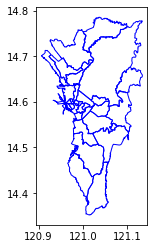

In [21]:
ax = plt.axes()
ax = admin3.plot(ax=ax, facecolor="none", edgecolor="blue")

![Admin 3 Levels for NCR](images/admin3-ncr.png)

In [22]:
# hide
# uncomment the statement below to show an interactive map
# admin3.explore(tooltip='ADM3_EN')

CPU times: user 115 ms, sys: 92.5 ms, total: 207 ms
Wall time: 105 ms


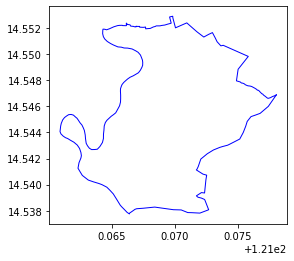

In [23]:
%%time
ax = plt.axes()
ax = admin3[admin3.ADM3_EN == "Pateros"].plot(ax=ax, facecolor="none", edgecolor="blue")

In [24]:
admin3.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
admin3.total_bounds

array([120.90639543,  14.35172957, 121.13503641,  14.78529173])

In [26]:
len(admin3)

30

### Download Ookla data

Use the `geowrangler.datasets.ookla` module to explore and download ookla (internet speed) data

In [27]:
from geowrangler.datasets import ookla

List the publically available ookla datasets

In [28]:
%%time
ookla_dsets = ookla.list_ookla_files()
ookla_dsets

CPU times: user 76.1 ms, sys: 14.5 ms, total: 90.5 ms
Wall time: 1.13 s


{OoklaQuarter(type='fixed', year='2019', quarter='1'): '2019-01-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2019', quarter='2'): '2019-04-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2019', quarter='3'): '2019-07-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2019', quarter='4'): '2019-10-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2020', quarter='1'): '2020-01-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2020', quarter='2'): '2020-04-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2020', quarter='3'): '2020-07-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2020', quarter='4'): '2020-10-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2021', quarter='1'): '2021-01-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2021', quarter='2'): '2021-04-01_performance_fixed_tiles.

Download the latest data (as of the time of writing this)

In [29]:
ookla_params = dict(year="2022", quarter="2", directory="../data")

In [30]:
%%time
ookla_fixed = ookla.download_ookla_file(type_="fixed", **ookla_params)

CPU times: user 143 µs, sys: 118 µs, total: 261 µs
Wall time: 182 µs


In [31]:
ookla_fixed

PosixPath('../data/2022-04-01_performance_fixed_tiles.parquet')

### Convert ookla data into a GeoDataFrame

The downloaded file from ookla is not yet a geodataset, so we will h
have to convert it into a `GeoDataFrame` suitable for use in geowrangler.

In [32]:
import pandas as pd

The downloaded ookla data contains the internet speed data for the whole world and can take a minute or two to load.

Later, we will show how to filter the data to only include the data relevant to our AOI.

In [33]:
%%time
fixed = pd.read_parquet(ookla_fixed)

CPU times: user 7.72 s, sys: 14.2 s, total: 21.9 s
Wall time: 19.2 s


In [34]:
len(fixed)

6581735

In [35]:
fixed.head()

,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
0,0000122200000000,"POLYGON((-168.75 84.1249731939109, -168.744506...",97075,42458,65,7,1
1,0022133222312322,"POLYGON((-160.02685546875 70.6435894914449, -1...",8324,3798,91,2,1
2,0022133222330100,"POLYGON((-160.02685546875 70.6417687358462, -1...",14972,4461,94,29,2
3,0022133222330201,"POLYGON((-160.043334960938 70.6344840663086, -...",6253,2818,91,1,1
4,0022202203233313,"POLYGON((-179.478149414062 68.9169336615194, -...",700,126,1090,1,1


In [36]:
fixed.dtypes

quadkey       object
tile          object
avg_d_kbps     int64
avg_u_kbps     int64
avg_lat_ms     int64
tests          int64
devices        int64
dtype: object

The data is now a Pandas `DataFrame` but this needs to be converted to a `GeoDataFrame` by converting the `tile` column into a `geometry` with a `crs` (Coordinate Reference System).

See [EPSG:4326](https://epsg.io/4326) for more details about the CRS.

Converting the data can also take a minute or two.

In [37]:
%%time
fixed["geometry"] = gpd.GeoSeries.from_wkt(fixed.tile, crs="EPSG:4326")

CPU times: user 30.1 s, sys: 1.55 s, total: 31.6 s
Wall time: 31.3 s


In [38]:
fixed.head()

,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,0000122200000000,"POLYGON((-168.75 84.1249731939109, -168.744506...",97075,42458,65,7,1,"POLYGON ((-168.75000 84.12497, -168.74451 84.1..."
1,0022133222312322,"POLYGON((-160.02685546875 70.6435894914449, -1...",8324,3798,91,2,1,"POLYGON ((-160.02686 70.64359, -160.02136 70.6..."
2,0022133222330100,"POLYGON((-160.02685546875 70.6417687358462, -1...",14972,4461,94,29,2,"POLYGON ((-160.02686 70.64177, -160.02136 70.6..."
3,0022133222330201,"POLYGON((-160.043334960938 70.6344840663086, -...",6253,2818,91,1,1,"POLYGON ((-160.04333 70.63448, -160.03784 70.6..."
4,0022202203233313,"POLYGON((-179.478149414062 68.9169336615194, -...",700,126,1090,1,1,"POLYGON ((-179.47815 68.91693, -179.47266 68.9..."


In [39]:
%%time
fixed.drop(columns=["tile"], inplace=True)

CPU times: user 515 ms, sys: 95.8 ms, total: 610 ms
Wall time: 606 ms


In [40]:
%%time
fixed = gpd.GeoDataFrame(fixed, geometry="geometry", crs="EPSG:4326")

CPU times: user 71.8 ms, sys: 61.1 ms, total: 133 ms
Wall time: 131 ms


### Validate AOI and Data Geometries

In order to prevent more headaches as we process and analyze geospatial datasets down the line, it is prudent to check 
that our datasets have valid geometries.

We can use the `geowrangler.validation` module to check as well fix these problems.

In [41]:
from geowrangler.validation import GeometryValidation

#### Validate AOI

In [42]:
admin3_gvm = GeometryValidation(admin3)

In [43]:
%%time
valid_admin3 = admin3_gvm.validate_all()

CPU times: user 306 ms, sys: 1.56 ms, total: 308 ms
Wall time: 306 ms


In [44]:
valid_admin3.head()

,Shape_Leng,Shape_Area,ADM3_EN,ADM3_PCODE,ADM3_REF,ADM3ALT1EN,ADM3ALT2EN,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry,is_not_null,is_not_self_intersecting,is_oriented_properly,is_within_crs_bounds,area_is_not_zero
211,0.037803,0.000056,Binondo,PH133902000,None,None,None,"NCR, City of Manila, First District",PH133900000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((120.97738 14.60226, 120.97765 14.602...",True,True,False,True,True
308,0.692758,0.004468,Caloocan City,PH137501000,None,None,None,"NCR, Third District",PH137500000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"MULTIPOLYGON (((121.01856 14.69176, 121.01846 ...",True,True,False,True,True
395,0.362306,0.002745,City of Las Piñas,PH137601000,City of Las Pinas,None,None,"NCR, Fourth District",PH137600000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"MULTIPOLYGON (((120.98122 14.48720, 120.98077 ...",True,True,False,True,True
398,0.260317,0.002094,City of Makati,PH137602000,None,None,None,"NCR, Fourth District",PH137600000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((121.03468 14.56725, 121.03416 14.567...",True,True,False,True,True
399,0.262034,0.001323,City of Malabon,PH137502000,None,None,None,"NCR, Third District",PH137500000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((120.92733 14.70265, 120.92690 14.702...",True,True,False,True,True


In [45]:
valid_cols = [
    "is_oriented_properly",
    "is_not_null",
    "is_not_self_intersecting",
    "is_within_crs_bounds",
    "area_is_not_zero",
]

In [46]:
[valid_admin3[col].value_counts() for col in valid_cols]

[False    30
 Name: is_oriented_properly, dtype: int64,
 True    30
 Name: is_not_null, dtype: int64,
 True    30
 Name: is_not_self_intersecting, dtype: int64,
 True    30
 Name: is_within_crs_bounds, dtype: int64,
 True    30
 Name: area_is_not_zero, dtype: int64]

So the admin areas have their geometry _improperly oriented_ (i.e. layed out in a counter clockwise direction instead of clockwise direction) and
this has been fixed, but passes all the other default validations.

In [47]:
valid_admin3.drop(
    columns=valid_cols,
    inplace=True,
)

#### Validate Data Geometries

Before validating, let's filter the data to only those intersecting our AOI because we don't need to check all the data from around the world
when we're only interested in our AOI.

Before we validate, we need to create the spatial indexes for both the AOI and data geometries. Generating the spatial 
indexes of the data geometries can take a minute or two due to the size of the data and their geometries.

In [48]:
%%time
valid_admin3.geometry.sindex

CPU times: user 1.12 ms, sys: 541 µs, total: 1.66 ms
Wall time: 1.61 ms


In [49]:
%%time
fixed.geometry.sindex

CPU times: user 6.12 s, sys: 4.01 s, total: 10.1 s
Wall time: 10.1 s


Lets now filter the data (`filtered_fixed`). 

Filtering the data using a spatial join can also take a minute or two.

In [50]:
%%time
filtered_fixed = fixed.sjoin(
    valid_admin3[["geometry"]], how="inner", predicate="intersects"
)

CPU times: user 1.97 s, sys: 688 ms, total: 2.66 s
Wall time: 2.67 s


In [51]:
filtered_fixed.drop(columns=["index_right"], inplace=True)

In [52]:
fixed_gvm = GeometryValidation(filtered_fixed)

In [53]:
%%time
valid_fixed = fixed_gvm.validate_all()

CPU times: user 676 ms, sys: 0 ns, total: 676 ms
Wall time: 673 ms


In [54]:
%%time
[valid_fixed[col].value_counts() for col in valid_cols]

CPU times: user 1.96 ms, sys: 961 µs, total: 2.92 ms
Wall time: 2.28 ms


[False    2300
 Name: is_oriented_properly, dtype: int64,
 True    2300
 Name: is_not_null, dtype: int64,
 True    2300
 Name: is_not_self_intersecting, dtype: int64,
 True    2300
 Name: is_within_crs_bounds, dtype: int64,
 True    2300
 Name: area_is_not_zero, dtype: int64]

Again the data geometries have an improperly oriented geometry and have been fixed by the validator

In [55]:
valid_fixed.drop(columns=valid_cols, inplace=True)
filtered_fixed = valid_fixed

![filtered fixed ookla data](images/fixed-ookla-admin3-ncr-2020q2.png)

In [56]:
# hide
# uncomment the statement below to show an interactive map
# filtered_fixed.explore(column='avg_d_kbps', cmap='viridis', tooltip='avg_d_kbps')


### Generate Zonal Stats


Lets now generate the zonal stats -- the statistics of the data we are interested in.

In [57]:
filtered_fixed.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
5646006,1323030313311323,43565,47889,8,93,23,"POLYGON ((120.92102 14.73770, 120.92102 14.732..."
5646008,1323030313311332,72579,91717,11,149,36,"POLYGON ((120.92651 14.73770, 120.92651 14.732..."
5646009,1323030313311333,52572,67337,3,1,1,"POLYGON ((120.93201 14.73770, 120.93201 14.732..."
5646018,1323030313313110,63548,77538,14,601,69,"POLYGON ((120.92651 14.73239, 120.92651 14.727..."
5646019,1323030313313111,105903,103874,13,115,22,"POLYGON ((120.93201 14.73239, 120.93201 14.727..."


In [58]:
list(filtered_fixed.columns.values)

['quadkey',
 'avg_d_kbps',
 'avg_u_kbps',
 'avg_lat_ms',
 'tests',
 'devices',
 'geometry']

In [59]:
len(filtered_fixed)

2300

Convert to planar CRS (since we are computing areas)

In [60]:
%%time
valid_admin3 = valid_admin3.to_crs("EPSG:3857")

CPU times: user 38.6 ms, sys: 0 ns, total: 38.6 ms
Wall time: 37.2 ms


In [61]:
%%time
filtered_fixed = filtered_fixed.to_crs("EPSG:3857")

CPU times: user 23.3 ms, sys: 1.52 ms, total: 24.8 ms
Wall time: 23.4 ms


Lets save the files so we can retrieve them as necessary without having to reprocess them again.

In [62]:
%%time
valid_admin3.to_file("../data/valid_admin3.geojson", driver="GeoJSON")

CPU times: user 539 ms, sys: 37.6 ms, total: 577 ms
Wall time: 574 ms


In [63]:
%%time
filtered_fixed.to_file("../data/filtered_fixed.geojson", driver="GeoJSON")

CPU times: user 583 ms, sys: 38.6 ms, total: 622 ms
Wall time: 620 ms


In [64]:
# %%time
# valid_admin3 = gpd.read_file("../data/valid_admin3.geojson")

In [65]:
# %%time
# filtered_fixed = gpd.read_file("../data/filtered_fixed.geojson")

We want the following statistics - `mean` (aka average), `min` (minimum), `max` (maximum) and the standard deviation (`std`)
for the 3 data columns that ookla provides - average download speed (`avg_d_kbps`), average upload speed (`avg_u_kbps`) and average latency in milliseconds (`avg_lat_ms`)

In [66]:
funcs = ["mean", "min", "max", "std"]
columns = ["avg_d_kbps", "avg_u_kbps", "avg_lat_ms"]

In [67]:
aggregations = [dict(func=funcs, column=c) for c in columns]

These are the aggregations to be performed for each data column

In [68]:
aggregations

[{'func': ['mean', 'min', 'max', 'std'], 'column': 'avg_d_kbps'},
 {'func': ['mean', 'min', 'max', 'std'], 'column': 'avg_u_kbps'},
 {'func': ['mean', 'min', 'max', 'std'], 'column': 'avg_lat_ms'}]

The output columns use the default `{column}_{func}` format if not explicitly specified.

In [69]:
%%time
aoi = azs.create_area_zonal_stats(
    valid_admin3, filtered_fixed, aggregations=aggregations
)

CPU times: user 3.74 s, sys: 0 ns, total: 3.74 s
Wall time: 3.73 s



### Analyze Zonal Stats


These are the results - the same dataframe as the original, with the addition of zonal statistics we specified as the aggregations.

In [70]:
aoi.head()

,Shape_Leng,Shape_Area,ADM3_EN,ADM3_PCODE,ADM3_REF,ADM3ALT1EN,ADM3ALT2EN,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry,intersect_area_sum,avg_d_kbps_mean,avg_d_kbps_min,avg_d_kbps_max,avg_d_kbps_std,avg_u_kbps_mean,avg_u_kbps_min,avg_u_kbps_max,avg_u_kbps_std,avg_lat_ms_mean,avg_lat_ms_min,avg_lat_ms_max,avg_lat_ms_std
211,0.037803,0.000056,Binondo,PH133902000,None,None,None,"NCR, City of Manila, First District",PH133900000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13467140.279 1643403.808, 13467170.0...",2.330890e+06,15125.377199,0.0,97827,4141.081774,12152.916247,0.0,80923,5625.791089,1.228832,0.0,8,0.923381
308,0.692758,0.004468,Caloocan City,PH137501000,None,None,None,"NCR, Third District",PH137500000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"MULTIPOLYGON (((13471724.654 1653701.565, 1347...",7.425998e+07,309.956521,0.0,123236,15346.775252,307.716950,0.0,117885,15118.576034,0.035243,0.0,59,6.147227
395,0.362306,0.002745,City of Las Piñas,PH137601000,City of Las Pinas,None,None,"NCR, Fourth District",PH137600000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"MULTIPOLYGON (((13467568.063 1630171.435, 1346...",4.080667e+07,649.603501,0.0,175810,22328.120899,555.324817,0.0,136167,19944.226971,0.045298,0.0,146,11.110505
398,0.260317,0.002094,City of Makati,PH137602000,None,None,None,"NCR, Fourth District",PH137600000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13473518.917 1639376.906, 13473461.1...",3.840895e+07,765.462383,0.0,159496,16771.721664,663.200995,0.0,144939,17818.361374,0.091436,0.0,25,5.288884
399,0.262034,0.001323,City of Malabon,PH137502000,None,None,None,"NCR, Third District",PH137500000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13461569.031 1654955.161, 13461520.7...",2.583556e+07,1006.838781,0.0,119622,13444.542392,933.345049,0.0,130002,14309.585589,0.096779,0.0,17,2.893162


Lets save the results 

In [71]:
%%time
aoi.to_file("../data/admin3_internet_aoi.geojson", driver="GeoJSON")

CPU times: user 415 ms, sys: 12.3 ms, total: 428 ms
Wall time: 424 ms


In [72]:
list(aoi.columns.values)

['Shape_Leng',
 'Shape_Area',
 'ADM3_EN',
 'ADM3_PCODE',
 'ADM3_REF',
 'ADM3ALT1EN',
 'ADM3ALT2EN',
 'ADM2_EN',
 'ADM2_PCODE',
 'ADM1_EN',
 'ADM1_PCODE',
 'ADM0_EN',
 'ADM0_PCODE',
 'date',
 'validOn',
 'validTo',
 'geometry',
 'intersect_area_sum',
 'avg_d_kbps_mean',
 'avg_d_kbps_min',
 'avg_d_kbps_max',
 'avg_d_kbps_std',
 'avg_u_kbps_mean',
 'avg_u_kbps_min',
 'avg_u_kbps_max',
 'avg_u_kbps_std',
 'avg_lat_ms_mean',
 'avg_lat_ms_min',
 'avg_lat_ms_max',
 'avg_lat_ms_std']

Let's sort the different admin level 3 areas (cities/municipalities/district) by average download speed (`avg_d_kbps_mean`)  in descending order

In [73]:
%%time
fastest_mean_download = aoi.sort_values("avg_d_kbps_mean", ascending=False)

CPU times: user 3.72 ms, sys: 0 ns, total: 3.72 ms
Wall time: 3.16 ms


In [74]:
len(fastest_mean_download)

30

So according the latest ookla data (as of this writing) the district/town/province within the NCR Region with the fastest average download speed is **Binondo**!! :)

In [75]:
fastest_mean_download.iloc[0]

Shape_Leng                                                     0.037803
Shape_Area                                                     0.000056
ADM3_EN                                                         Binondo
ADM3_PCODE                                                  PH133902000
ADM3_REF                                                           None
ADM3ALT1EN                                                         None
ADM3ALT2EN                                                         None
ADM2_EN                             NCR, City of Manila, First District
ADM2_PCODE                                                  PH133900000
ADM1_EN                                         National Capital Region
ADM1_PCODE                                                  PH130000000
ADM0_EN                                               Philippines (the)
ADM0_PCODE                                                           PH
date                                                         201

While the district/city/municipality within the NCR Regions with the slowest average download speed is **Quezon City**!!! 

In [76]:
fastest_mean_download.iloc[-1]

Shape_Leng                                                     0.773902
Shape_Area                                                      0.01363
ADM3_EN                                                     Quezon City
ADM3_PCODE                                                  PH137404000
ADM3_REF                                                           None
ADM3ALT1EN                                                         None
ADM3ALT2EN                                                         None
ADM2_EN                                            NCR, Second District
ADM2_PCODE                                                  PH137400000
ADM1_EN                                         National Capital Region
ADM1_PCODE                                                  PH130000000
ADM0_EN                                               Philippines (the)
ADM0_PCODE                                                           PH
date                                                         201

The top 5 fastest areas are

In [77]:
fastest_mean_download[["ADM3_EN", "ADM2_EN", "avg_d_kbps_mean"]].head()

,ADM3_EN,ADM2_EN,avg_d_kbps_mean
211,Binondo,"NCR, City of Manila, First District",15125.377199
1343,San Nicolas,"NCR, City of Manila, First District",10897.783018
1192,Quiapo,"NCR, City of Manila, First District",9799.121085
1336,San Miguel,"NCR, City of Manila, First District",8708.791412
1112,Pateros,"NCR, Fourth District",7581.975774


The top 5 slowest areas are

In [78]:
fastest_mean_download[["ADM3_EN", "ADM2_EN", "avg_d_kbps_mean"]].tail()

,ADM3_EN,ADM2_EN,avg_d_kbps_mean
1521,Taguig City,"NCR, Fourth District",531.559943
411,City of Parañaque,"NCR, Fourth District",470.491966
436,City of Valenzuela,"NCR, Third District",420.083766
308,Caloocan City,"NCR, Third District",309.956521
1191,Quezon City,"NCR, Second District",145.111131


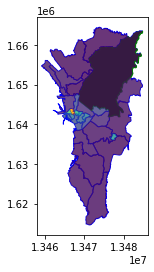

In [79]:
ax = plt.axes()
ax = fastest_mean_download.plot(ax=ax, facecolor="none", edgecolor="blue")
ax = fastest_mean_download.iloc[:1].plot(ax=ax, facecolor="red", edgecolor="red")
ax = fastest_mean_download.iloc[29:].plot(ax=ax, facecolor="green", edgecolor="green")
ax = fastest_mean_download.plot(ax=ax, column="avg_d_kbps_mean", alpha=0.8)

![fastest fixed ookla by adm3](images/fastest-fixed-ookla-by-adm3.png)

In [80]:
# hide
# uncomment the statement below to show an interactive map
# fastest_mean_download.explore(column='avg_d_kbps_mean',cmap='viridis', tooltip='avg_d_kbps_mean')

So now, we've answered the question of where the fastest/slowest internet speeds are for the National Capital Region (NCR)

### Additional Exercises

You can further experiment and try out other exercises to explore ookla data, or even try it out using
a different country using a different geodataset from the Humanitarian Data Exchange site. 

The following are more exercises you can try:

* Repeat the same process to find the fastest and slowest **mobile** internet speeds
* Repeat the same process for a different REGION_FILTER
* Aggregate by adm2 level instead of adm3
